## Saving a Cats Meow v Dogs Bork Model

This is a minimal example showing how to train a fastai model on Kaggle, and save it so you can use it in your app.

In [1]:
# Make sure we've got the latest version of fastai:
!pip install -Uqq fastai nbdev

In [2]:
from fastai.vision.all import *
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
import shutil

Download ESC-50 dataset and set up the directories:

In [3]:
# Remove old zips
!rm -rf /kaggle/working/*.zip*

# Download ESC-50 dataset
!wget -q https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip -q -o master.zip

# Load metadata
meta_df = pd.read_csv('ESC-50-master/meta/esc50.csv')

# Create directories
cat_folder = Path('animal_sounds/cat')
dog_folder = Path('animal_sounds/dog')
cat_folder.mkdir(parents=True, exist_ok=True)
dog_folder.mkdir(parents=True, exist_ok=True)

# Extract cat and dog files
cat_files = meta_df[meta_df['category'] == 'cat']
dog_files = meta_df[meta_df['category'] == 'dog']

# Copy files to respective folders
for _, row in cat_files.iterrows():
    src = f"ESC-50-master/audio/{row['filename']}"
    dst = f"animal_sounds/cat/{row['filename']}"
    shutil.copy(src, dst)
    
for _, row in dog_files.iterrows():
    src = f"ESC-50-master/audio/{row['filename']}"
    dst = f"animal_sounds/dog/{row['filename']}"
    shutil.copy(src, dst)

print(f"Copied {len(cat_files)} cat sounds and {len(dog_files)} dog sounds")

# Now use 'animal_sounds' as your audio_folder
audio_folder = 'animal_sounds'

Copied 40 cat sounds and 40 dog sounds


Download a separate cat and dog dataset:

In [4]:
# Path to the dataset in the input section
dataset_path = Path("/kaggle/input/audio-cats-and-dogs")

# Get all cat files from both test and train directories
cat_files = list(dataset_path.glob("cats_dogs/test/cats/*")) + list(dataset_path.glob("cats_dogs/train/cat/*"))

# Get all dog files from both test and train directories  
dog_files = list(dataset_path.glob("cats_dogs/test/dogs/*")) + list(dataset_path.glob("cats_dogs/train/dog/*"))

# Copy files to respective folders
for filepath in cat_files:
    src = filepath
    filename = Path(filepath).name
    dst = f"animal_sounds/cat/{filename}"
    shutil.copy(src, dst)
    
for filepath in dog_files:
    src = filepath
    filename = Path(filepath).name
    dst = f"animal_sounds/dog/{filename}"
    shutil.copy(src, dst)

Create a helper function to generate spectrograms:

In [5]:
def create_spectrogram(audio_path, save_path=None):
    y, sr = librosa.load(audio_path)
    # create mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128
    )
    # convert to log scale (dB)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # plot and save as image
    plt.figure(figsize=(8,6))
    librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel')
    plt.tight_layout()
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        return save_path
    else:
        plt.close()
        return log_mel_spec

In [6]:
# Set up folders
spec_folder = './spectrograms'
Path(spec_folder).mkdir(exist_ok=True, parents=True)

# Process audio files to spectrograms
for label in ['cat', 'dog']:
    (Path(spec_folder)/label).mkdir(exist_ok=True)

    audio_path = Path(f"{audio_folder}/{label}")
    if audio_path.exists():
        files = list(audio_path.glob("*.wav"))
        print(f"Processing {len(files)} {label} audio files...")

        for i, file in enumerate(files):
            output_file = Path(spec_folder)/label/f"{file.stem}.png"
            create_spectrogram(str(file), str(output_file))
            if i % 10 == 0:
                print(f"Processed {i}/{len(files)} files")

print(f"Total spectrograms created: {len(list(Path(spec_folder).glob('**/*.png')))}")

Processing 204 cat audio files...
Processed 0/204 files
Processed 10/204 files
Processed 20/204 files
Processed 30/204 files
Processed 40/204 files
Processed 50/204 files
Processed 60/204 files
Processed 70/204 files
Processed 80/204 files
Processed 90/204 files
Processed 100/204 files
Processed 110/204 files
Processed 120/204 files
Processed 130/204 files
Processed 140/204 files
Processed 150/204 files
Processed 160/204 files
Processed 170/204 files
Processed 180/204 files
Processed 190/204 files
Processed 200/204 files
Processing 125 dog audio files...
Processed 0/125 files
Processed 10/125 files
Processed 20/125 files
Processed 30/125 files
Processed 40/125 files
Processed 50/125 files
Processed 60/125 files
Processed 70/125 files
Processed 80/125 files
Processed 90/125 files
Processed 100/125 files
Processed 110/125 files
Processed 120/125 files
Total spectrograms created: 329


In [7]:
sample_cat = list(Path(f"{spec_folder}/cat").glob("*.png"))[0]
sample_dog = list(Path(f"{spec_folder}/dog").glob("*.png"))[0]

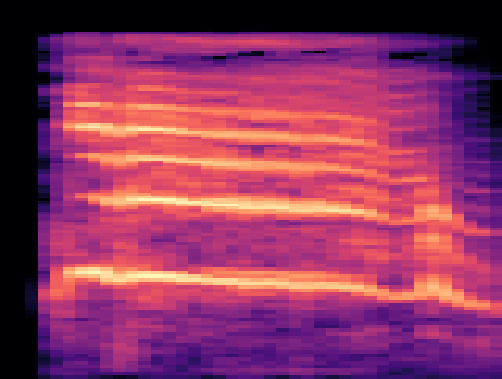

In [8]:
Image.open(sample_cat)

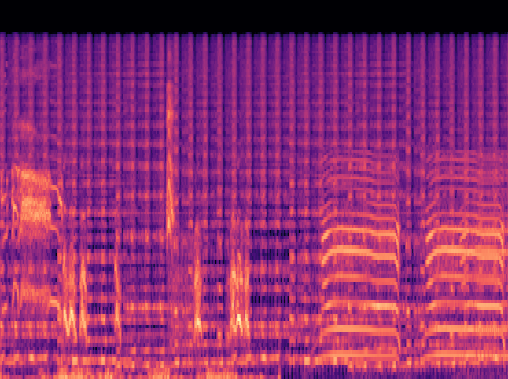

In [9]:
Image.open(sample_dog)

**Note:** Unpacking the `aug_transforms()` function was helpful to control specific parameters rather than using the defaults. Playing with the spectrograms rotation, zoom, lighting, and warping helped with lowering error rate and getting a better loss.
Now we can create our `DataLoaders`:

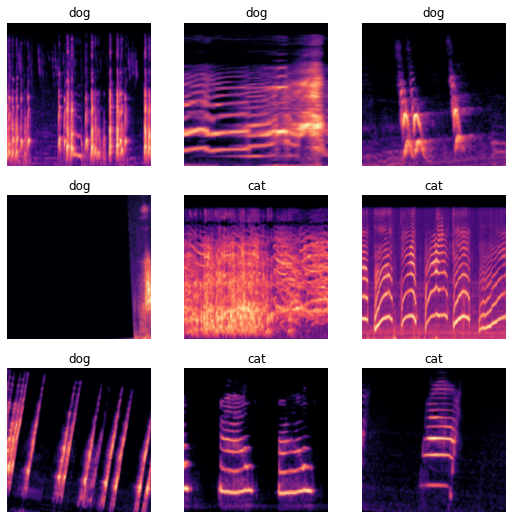

In [10]:
# Create DataBlock and train model
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms = [
        *aug_transforms(max_rotate=10, max_zoom=1.1, max_lighting=0.2, max_warp=0),
        Normalize.from_stats(*imagenet_stats)
    ]
)

dls = dblock.dataloaders(spec_folder, bs=16)
dls.show_batch()

... and train our model, a resnet50:

In [11]:
learner = vision_learner(dls, resnet50, metrics=error_rate)

Plot the loss vs learning rate to reduce amount of guesswork on picking a good starting learning rate:

SuggestedLRs(valley=0.002511886414140463)

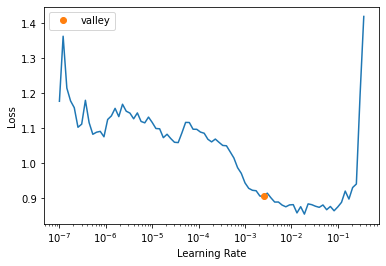

In [12]:
 learner.lr_find()

Fine tune the model. Stopping early when `valid_loss` stops improving and saving the model's best run during training and loads it at the end.

In [13]:
learner.fine_tune(150, base_lr=10e-3, cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=20), SaveModelCallback()])

epoch,train_loss,valid_loss,error_rate,time
0,1.043078,1.618788,0.292308,00:02


Better model found at epoch 0 with valid_loss value: 1.618788242340088.


epoch,train_loss,valid_loss,error_rate,time
0,0.645169,0.730335,0.123077,00:03
1,0.547746,0.287895,0.076923,00:02
2,0.431976,0.283985,0.076923,00:02
3,0.421376,0.219500,0.046154,00:02
4,0.338570,0.286419,0.076923,00:02
5,0.273144,0.230445,0.076923,00:02
6,0.287405,0.151524,0.030769,00:02
7,0.272559,0.099437,0.046154,00:02
8,0.247019,0.152136,0.061538,00:02
9,0.239697,0.171235,0.061538,00:02


Better model found at epoch 0 with valid_loss value: 0.7303350567817688.
Better model found at epoch 1 with valid_loss value: 0.2878950834274292.
Better model found at epoch 2 with valid_loss value: 0.2839854061603546.
Better model found at epoch 3 with valid_loss value: 0.21949966251850128.
Better model found at epoch 6 with valid_loss value: 0.15152423083782196.
Better model found at epoch 7 with valid_loss value: 0.09943736344575882.
Better model found at epoch 20 with valid_loss value: 0.09838863462209702.
Better model found at epoch 31 with valid_loss value: 0.0676436647772789.
No improvement since epoch 31: early stopping


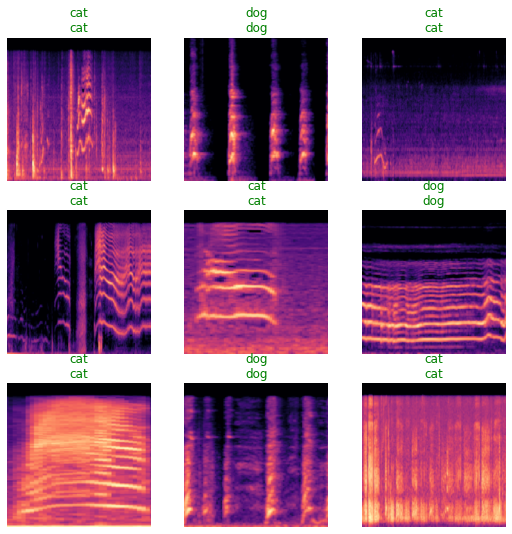

In [14]:
learner.show_results()

Now we can export our trained `Learner`. This contains all the information needed to run the model:

In [15]:
learner.export('cat-meow-vs-dog-bork.pkl')

Finally, open the Kaggle sidebar on the right if it's not already, and find the section marked "Output". Open the `/kaggle/working` folder, and you'll see `model.pkl`. Click on it, then click on the menu on the right that appears, and choose "Download". After a few seconds, your model will be downloaded to your computer, where you can then create your app that uses the model.